In [421]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [422]:
df=pd.read_csv('./HDFC.csv',index_col='Date',parse_dates=True)

Data Pre processing


In [423]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HDFC,EQ,271.75,293.50,293.50,293.50,293.50,293.50,293.50,22744,6.675364e+11,NaN,NaN,NaN
2000-01-04,HDFC,EQ,293.50,317.00,317.00,297.00,304.00,304.05,303.62,255251,7.749972e+12,NaN,NaN,NaN
2000-01-05,HDFC,EQ,304.05,290.00,303.90,285.00,295.00,292.80,294.53,269087,7.925368e+12,NaN,NaN,NaN
2000-01-06,HDFC,EQ,292.80,301.00,314.00,295.00,296.00,296.45,300.14,305916,9.181669e+12,NaN,NaN,NaN
2000-01-07,HDFC,EQ,296.45,290.00,296.35,281.00,287.10,286.55,288.80,197039,5.690480e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HDFC,EQ,2497.35,2500.00,2534.10,2483.20,2502.00,2509.80,2508.07,3916088,9.821805e+14,121028.0,2440395.0,0.6232
2021-04-27,HDFC,EQ,2509.80,2494.15,2526.80,2486.25,2514.00,2518.40,2509.18,2040799,5.120730e+14,102250.0,1040749.0,0.5100
2021-04-28,HDFC,EQ,2518.40,2516.10,2609.00,2508.30,2575.00,2577.00,2574.21,3407461,8.771527e+14,117425.0,1815110.0,0.5327


In [424]:
df['Date']=df.index

In [425]:
start_date='2011-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [426]:
df=df.loc[mask]

In [428]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [429]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [430]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [431]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [432]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (2427, 50) Y.shape (2427,)


In [433]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

ANN

In [434]:
i=Input(shape=(T,))
x=Dense(400,activation='relu')(i)
x=Dense(100,activation='relu')(x)
x=Dense(50,activation='relu')(x)
x=Dense(1,activation='relu')(x)
model_ann=Model(i,x)
model_ann.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 50)]              0         
                                                                 
 dense_77 (Dense)            (None, 400)               20400     
                                                                 
 dense_78 (Dense)            (None, 100)               40100     
                                                                 
 dense_79 (Dense)            (None, 50)                5050      
                                                                 
 dense_80 (Dense)            (None, 1)                 51        
                                                                 
Total params: 65,601
Trainable params: 65,601
Non-trainable params: 0
_________________________________________________________________


In [435]:
model_ann.compile(
    loss='mse',
    optimizer='adamax',
    metrics='mae'
)

In [436]:
r=model_ann.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
53/53 [==============================] - 1s 5ms/step - loss: 291.3974 - mae: 12.6785 - val_loss: 1637.2264 - val_mae: 27.8528
Epoch 2/100
53/53 [==============================] - 0s 2ms/step - loss: 290.3817 - mae: 12.6360 - val_loss: 1637.4379 - val_mae: 27.8645
Epoch 3/100
53/53 [==============================] - 0s 2ms/step - loss: 290.1626 - mae: 12.6271 - val_loss: 1637.3064 - val_mae: 27.8584
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 289.9619 - mae: 12.6143 - val_loss: 1637.5886 - val_mae: 27.8696
Epoch 5/100
53/53 [==============================] - 0s 2ms/step - loss: 289.7853 - mae: 12.6092 - val_loss: 1636.9218 - val_mae: 27.8697
Epoch 6/100
53/53 [==============================] - 0s 2ms/step - loss: 289.6311 - mae: 12.5942 - val_loss: 1637.2828 - val_mae: 27.8571
Epoch 7/100
53/53 [==============================] - 0s 2ms/step - loss: 289.1445 - mae: 12.5873 - val_loss: 1636.6923 - val_mae: 27.8601
Epoch 8/100
53/53 [===============

CNN

In [437]:
i=Input(shape=(T,1))
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(1)(x)
model_cnn=Model(i,x)
model_cnn.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 conv1d_14 (Conv1D)          (None, 48, 25)            100       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 24, 25)           0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d_21 (Gl  (None, 50)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_81 (Dense)            (None, 1)                 51 

In [438]:
model_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [439]:
r=model_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
53/53 [==============================] - 1s 7ms/step - loss: 305.7083 - mae: 13.0534 - mse: 305.7083 - val_loss: 1699.4352 - val_mae: 28.5293 - val_mse: 1699.4352
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 294.4205 - mae: 12.7856 - mse: 294.4205 - val_loss: 1663.0085 - val_mae: 28.1358 - val_mse: 1663.0085
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 291.7899 - mae: 12.7154 - mse: 291.7899 - val_loss: 1663.8185 - val_mae: 28.1362 - val_mse: 1663.8185
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 290.3795 - mae: 12.6659 - mse: 290.3795 - val_loss: 1661.8240 - val_mae: 28.1166 - val_mse: 1661.8240
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 288.1201 - mae: 12.6193 - mse: 288.1201 - val_loss: 1690.7742 - val_mae: 28.2848 - val_mse: 1690.7742
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 287.9232 - mae: 12.6319 - mse: 287.9232 - val_loss: 

LSTM

In [440]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm=Model(i,x)
model_lstm.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 lstm_14 (LSTM)              (None, 50, 200)           161600    
                                                                 
 lstm_15 (LSTM)              (None, 50, 200)           320800    
                                                                 
 global_max_pooling1d_22 (Gl  (None, 200)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_82 (Dense)            (None, 100)               20100     
                                                                 
 dense_83 (Dense)            (None, 50)                5050      
                                                          

In [441]:
check_point_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [442]:
model_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [443]:
r=model_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm]
)

Epoch 1/100
53/53 [==============================] - 12s 182ms/step - loss: 293.3954 - mae: 12.7342 - mse: 293.3954 - val_loss: 1636.6086 - val_mae: 27.8389 - val_mse: 1636.6086
Epoch 2/100
53/53 [==============================] - 9s 166ms/step - loss: 291.4254 - mae: 12.6828 - mse: 291.4254 - val_loss: 1636.2589 - val_mae: 27.8305 - val_mse: 1636.2589
Epoch 3/100
53/53 [==============================] - 9s 169ms/step - loss: 291.1841 - mae: 12.6877 - mse: 291.1841 - val_loss: 1636.2163 - val_mae: 27.8291 - val_mse: 1636.2163
Epoch 4/100
53/53 [==============================] - 9s 168ms/step - loss: 291.1802 - mae: 12.6912 - mse: 291.1802 - val_loss: 1637.0493 - val_mae: 27.8412 - val_mse: 1637.0493
Epoch 5/100
53/53 [==============================] - 9s 168ms/step - loss: 291.1026 - mae: 12.6656 - mse: 291.1026 - val_loss: 1636.1379 - val_mae: 27.8258 - val_mse: 1636.1379
Epoch 6/100
53/53 [==============================] - 9s 167ms/step - loss: 291.1290 - mae: 12.6837 - mse: 291.1290

GRU

In [444]:
i=Input(shape=(T,1))
x=GRU(200,return_sequences=True)(i)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_gru=Model(i,x)
model_gru.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fe98461f250>>

In [445]:
check_point_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [446]:
model_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [447]:
r=model_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_gru]
)

Epoch 1/100
53/53 [==============================] - 11s 159ms/step - loss: 297.6253 - mae: 12.8580 - mse: 297.6253 - val_loss: 1641.1420 - val_mae: 27.8995 - val_mse: 1641.1420
Epoch 2/100
53/53 [==============================] - 8s 147ms/step - loss: 291.8214 - mae: 12.7073 - mse: 291.8214 - val_loss: 1637.4358 - val_mae: 27.8369 - val_mse: 1637.4358
Epoch 3/100
53/53 [==============================] - 8s 146ms/step - loss: 291.2803 - mae: 12.6992 - mse: 291.2803 - val_loss: 1637.6117 - val_mae: 27.8344 - val_mse: 1637.6117
Epoch 4/100
53/53 [==============================] - 8s 151ms/step - loss: 291.0597 - mae: 12.6854 - mse: 291.0597 - val_loss: 1640.0217 - val_mae: 27.8672 - val_mse: 1640.0217
Epoch 5/100
53/53 [==============================] - 8s 148ms/step - loss: 290.6194 - mae: 12.6575 - mse: 290.6194 - val_loss: 1638.2130 - val_mae: 27.8213 - val_mse: 1638.2130
Epoch 6/100
53/53 [==============================] - 8s 148ms/step - loss: 291.0488 - mae: 12.6806 - mse: 291.0488

Predictions

In [448]:
train_idx[:T+1]=False

In [449]:
Ptrain_ann=model_ann.predict(Xtrain).flatten()
Ptest_ann=model_ann.predict(Xtest).flatten()


In [450]:
Ptrain_cnn=model_cnn.predict(Xtrain).flatten()
Ptest_cnn=model_cnn.predict(Xtest).flatten()

In [451]:
Ptrain_lstm=model_lstm.predict(Xtrain).flatten()
Ptest_lstm=model_lstm.predict(Xtest).flatten()

In [452]:
Ptrain_gru=model_gru.predict(Xtrain).flatten()
Ptest_gru=model_gru.predict(Xtest).flatten()

In [453]:
df.loc[train_idx,'Diff ANN train prediction']=Ptrain_ann
df.loc[test_idx,'Diff ANN test prediction']=Ptest_ann

In [454]:
df.loc[train_idx,'Diff CNN train prediction']=Ptrain_cnn
df.loc[test_idx,'Diff CNN test prediction']=Ptest_cnn

In [455]:
df.loc[train_idx,'Diff LSTM train prediction']=Ptrain_lstm
df.loc[test_idx,'Diff LSTM test prediction']=Ptest_lstm

In [456]:
df.loc[train_idx,'Diff GRU train prediction']=Ptrain_gru
df.loc[test_idx,'Diff GRU test prediction']=Ptest_gru

In [457]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [458]:
last_train=train.iloc[-1]['Prev Close']

In [459]:
df.loc[train_idx,'train_ANN']=prev[train_idx]+Ptrain_ann
df.loc[test_idx,'Prediction_ANN']=prev[test_idx]+Ptest_ann

In [460]:
df.loc[train_idx,'train_CNN']=prev[train_idx]+Ptrain_cnn
df.loc[test_idx,'Prediction_CNN']=prev[test_idx]+Ptest_cnn

In [461]:
df.loc[train_idx,'train_LSTM']=prev[train_idx]+Ptrain_lstm
df.loc[test_idx,'Prediction_LSTM']=prev[test_idx]+Ptest_lstm

In [462]:
df.loc[train_idx,'train_GRU']=prev[train_idx]+Ptrain_gru
df.loc[test_idx,'Prediction_GRU']=prev[test_idx]+Ptest_gru

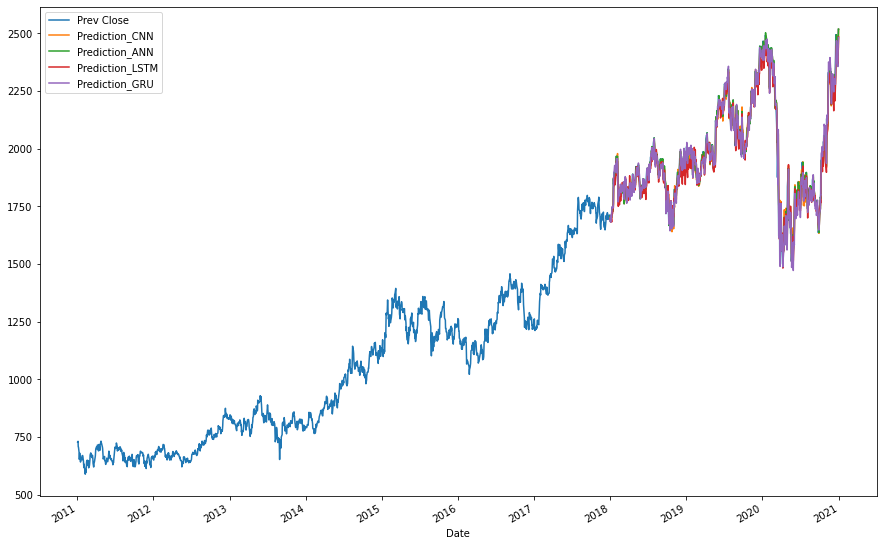

In [463]:
df[[ 'Prev Close','Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10));

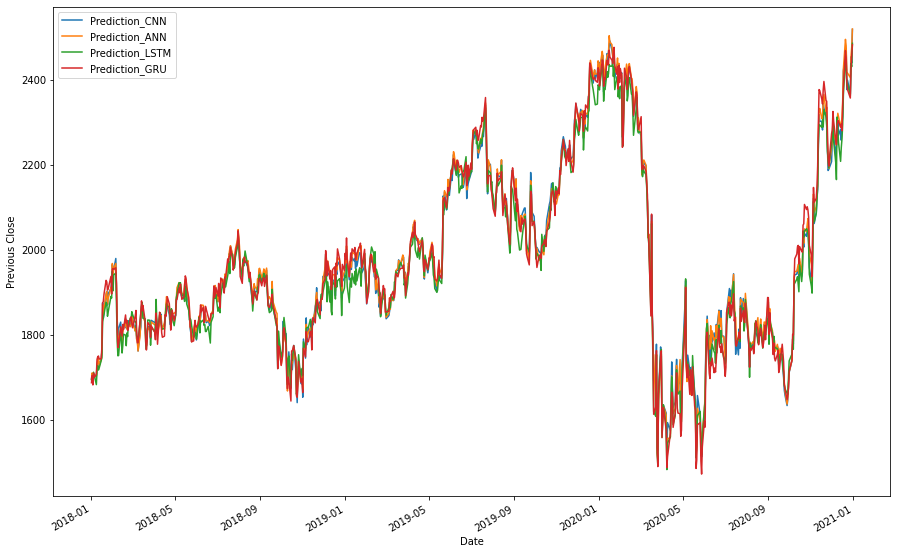

In [464]:
df[[ 'Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10),
    ylabel=("Previous Close"));

Evaluation

In [465]:
pred_ann=df['Prediction_ANN']
pred_ann.dropna(inplace=True)

In [466]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_ann))
print(rmse)

41.00483939804816


In [467]:
error=mean_absolute_error(test['Prev Close'],pred_ann)
print(error)

28.32494777062981


In [468]:
r2_score(test['Prev Close'],pred_ann)

0.9648478730781718

In [469]:
pred_cnn=df['Prediction_CNN']
pred_cnn.dropna(inplace=True)

In [470]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_cnn))
print(rmse)

42.55262963910861


In [471]:
error=mean_absolute_error(test['Prev Close'],pred_cnn)
print(error)

29.758503986214585


In [472]:
r2_score(test['Prev Close'],pred_cnn)

0.962144046966024

In [473]:
pred_lstm=df['Prediction_LSTM']
pred_lstm.dropna(inplace=True)

In [474]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm))
print(rmse)

48.25354851726065


In [475]:
error=mean_absolute_error(test['Prev Close'],pred_lstm)
print(error)

35.62931157673633


In [476]:
r2_score(test['Prev Close'],pred_lstm)

0.951321197052842

In [477]:
pred_gru=df['Prediction_GRU']
pred_gru.dropna(inplace=True)

In [478]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_gru))
print(rmse)

45.670766506097685


In [479]:
error=mean_absolute_error(test['Prev Close'],pred_gru)
print(error)

32.923408280811394


In [480]:
r2_score(test['Prev Close'],pred_gru)

0.9563928224335386